fork from: https://arxiv.org/pdf/1801.04062.pdf

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Make toy data

### Type 1. Independent Gaussian

$$
{\bf x}_i = \left( \begin{array}{c}x_{i1} \\ x_{i2} \end{array} \right) \sim \mathcal{N} \left( \left[ \begin{array}{c}0 \\ 0 \end{array} \right],\begin{bmatrix}1&0\\ 0&1\end{bmatrix} \right) ~~~~~ i = 1 \sim 300
$$

In [2]:
x = np.random.multivariate_normal( mean=[0,0],
                                  cov=[[1,0],[0,1]],
                                 size = 300)
x.shape

(300, 2)

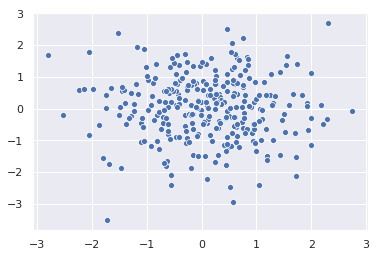

In [6]:
# plt indep Gaussian
sns.scatterplot(x[:,0],x[:,1])

### Type 2. Correlated Gaussian

$$
{\bf y}_i = \left( \begin{array}{c}y_{i1} \\ y_{i2} \end{array} \right) \sim \mathcal{N} \left( \left[ \begin{array}{c}0 \\ 0 \end{array} \right],\begin{bmatrix}1&0.8\\ 0.8&1\end{bmatrix} \right) ~~~~~ i = 1 \sim 300
$$

In [7]:
y = np.random.multivariate_normal( mean=[0,0],
                                  cov=[[1,0.8],[0.8,1]],
                                 size = 300)
y.shape

(300, 2)

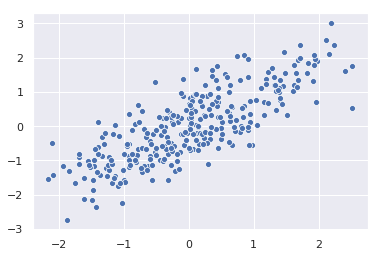

In [8]:
# plt cor Gaussian
sns.scatterplot(y[:,0], y[:,1])

# Define MINE

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd

### Data

In [10]:
def sample_batch(data, batch_size=100, sample_mode='joint'):
    if sample_mode == 'joint':
        index_1 = np.random.choice(range(data.shape[0]), size=batch_size, replace=False)
        batch = data[index_1]
    elif sample_mode == 'marginal':
        index_1 = np.random.choice(range(data.shape[0]), size=batch_size, replace=False)
        index_2 = np.random.choice(range(data.shape[0]), size=batch_size, replace=False)
        batch = np.concatenate([data[index_1][:,0].reshape(-1,1), data[index_2][:,1].reshape(-1,1)], axis=1)
    return batch

In [24]:
x = np.random.multivariate_normal( mean=[0,0],
                                  cov=[[1,0],[0,1]],
                                 size = 300)

y = np.random.multivariate_normal( mean=[0,0],
                                  cov=[[1,0.8],[0.8,1]],
                                 size = 300)

In [25]:
y.shape

(300, 2)

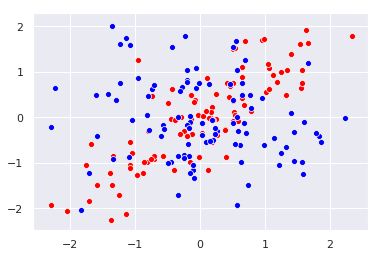

In [17]:
# joint
joint_data = sample_batch(y, batch_size=100,sample_mode='joint')
sns.scatterplot(x=joint_data[:,0], y=joint_data[:,1], color='red')

# marginal
marginal_data = sample_batch(y, batch_size=100,sample_mode='marginal')
sns.scatterplot(x=marginal_data[:,0], y=marginal_data[:,1], color='blue')

In [23]:
print(joint_data.shape)
print(marginal_data.shape)

(100, 2)
(100, 2)


## MINE

In [55]:
class StochasticNet(nn.Module):
    def __init__(self, xdim=1, y_dim=1, hidden_size=100):
        super().__init__()
        self.xdim = xdim
        self.ydim = ydim
        
        self.fc1 = nn.Linear(xdim+ydim, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 1)
        nn.init.normal_(self.fc1.weight,std=0.02)
        nn.init.constant_(self.fc1.bias, 0)
        nn.init.normal_(self.fc2.weight,std=0.02)
        nn.init.constant_(self.fc2.bias, 0)
        nn.init.normal_(self.fc3.weight,std=0.02)
        nn.init.constant_(self.fc3.bias, 0)
        
    def forward(self, input):
        output = F.elu(self.fc1(input))
        output = F.elu(self.fc2(output))
        output = self.fc3(output)
        return output

In [56]:
def calc_MI_LowerBound(joint, marginal, net):
    t = net(joint)
    et = torch.exp(net(marginal))
    mi_lb = torch.mean(t) - torch.log(torch.mean(et)) # Lower bound for MI
    return mi_lb, t, et

In [64]:
def update(batch, net, optimizer,  ma_et, ma_rate=0.01):
    # batch is a tuple of (joint, marginal)
    joint_batch , marginal_batch = batch
    joint_batch = torch.autograd.Variable(torch.FloatTensor(joint_batch)).cuda()
    marginal_batch = torch.autograd.Variable(torch.FloatTensor(marginal_batch)).cuda()
    
    mi_lb , t, et = calc_MI_LowerBound(joint_batch, marginal_batch, net)
    ma_et = (1 - ma_rate) * ma_et + ma_rate * torch.mean(et)
    
    # unbiasing use moving average
    loss = -(torch.mean(t) - (1/ma_et.mean()).detach() * torch.mean(et))

    # use biased estimator
    # loss = - mi_lb
    
    optimizer.zero_grad()
    autograd.backward(loss)
    optimizer.step()
    
    return mi_lb, ma_et

In [65]:
def train(data, net, optimizer, batch_size=100, nb_epoch=int(5e+3), log_freq=int(1e+3)):
    # data is x or y
    result = list()
    
    # moving average
    ma_et = 1.
    
    for i in range(nb_epoch):
        batch_data = sample_batch(data, batch_size=batch_size, sample_mode='joint'), sample_batch(data, batch_size=batch_size, sample_mode='marginal')
        
        mi_lb, ma_et = update(batch_data, net, optimizer, ma_et)
        
        result.append(mi_lb.detach().cpu().numpy())
        
        if (i+1)%(log_freq) == 0:
            print("epoch: ", i+1, "  MI lower bounds: ", result[-1])
            
    return result

In [66]:
# moving average
def ma(array, window_size=100):
    return [np.mean(array[i:i+window_size]) for i in range(0, len(array) - window_size)]

In [67]:
net = StochasticNet(xdim=1, y_dim=1).cuda()
optimizer = optim.Adam(net.parameters(), lr=1e-3)

mi_lower_bound = train(y, net, optimizer)

epoch:  1000   MI lower bounds:  0.5742397
epoch:  2000   MI lower bounds:  0.52258015
epoch:  3000   MI lower bounds:  0.324335
epoch:  4000   MI lower bounds:  0.5146305
epoch:  5000   MI lower bounds:  0.45850265


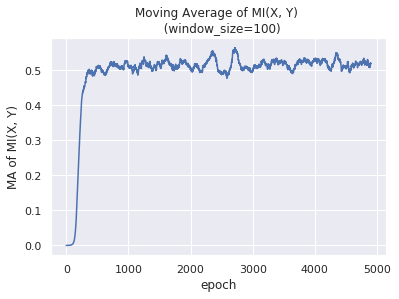

Final value of MI:  0.51963735


In [68]:
# MI lower boundsのプロット

mi_lower_bound_ma = ma(mi_lower_bound)

plt.title("Moving Average of MI(X, Y) \n  (window_size=100)")
plt.xlabel("epoch")
plt.ylabel("MA of MI(X, Y)")
plt.plot(range(len(mi_lower_bound_ma)), mi_lower_bound_ma)
plt.show()

print("Final value of MI: ", mi_lower_bound_ma[-1])

In [69]:
net = StochasticNet().cuda()
optimizer = optim.Adam(net.parameters(), lr=1e-3)

mi_lower_bound = train(x, net, optimizer)

epoch:  1000   MI lower bounds:  4.9364753e-06
epoch:  2000   MI lower bounds:  1.202507e-05
epoch:  3000   MI lower bounds:  -1.4307734e-06
epoch:  4000   MI lower bounds:  -0.00012311852
epoch:  5000   MI lower bounds:  -1.7129307e-05


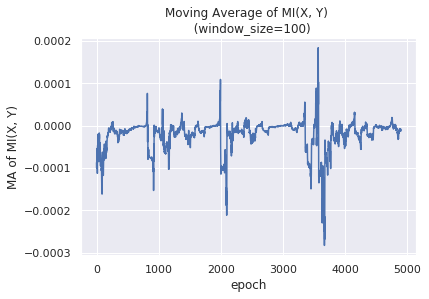

Final value of MI:  -1.232513e-05


In [70]:
# MI lower boundsのプロット

mi_lower_bound_ma = ma(mi_lower_bound)

plt.title("Moving Average of MI(X, Y) \n  (window_size=100)")
plt.xlabel("epoch")
plt.ylabel("MA of MI(X, Y)")
plt.plot(range(len(mi_lower_bound_ma)), mi_lower_bound_ma)
plt.show()

print("Final value of MI: ", mi_lower_bound_ma[-1])